In [1]:
import copy
from glob import glob
import pickle
import munch

import math
import torch as th
import numpy as np
import scipy as sp
import scipy.signal as _

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8.5]

## Autoencoder Data Preparation

In [2]:
filenames = sorted(glob('data/rest/*.pkl'))
filenames

['data/rest/s08-3minutes.pkl',
 'data/rest/s08-letter-b.pkl',
 'data/rest/s08-letter-d.pkl',
 'data/rest/s08-letter-p.pkl',
 'data/rest/s08-mentaltasks.pkl',
 'data/rest/s10-3minutes.pkl',
 'data/rest/s10-letter-b.pkl',
 'data/rest/s10-letter-d.pkl',
 'data/rest/s10-letter-p.pkl',
 'data/rest/s10-mentaltasks.pkl',
 'data/rest/s11-3minutes.pkl',
 'data/rest/s11-letter-b.pkl',
 'data/rest/s11-letter-d.pkl',
 'data/rest/s11-letter-p.pkl',
 'data/rest/s11-mentaltasks.pkl',
 'data/rest/s12-3minutes.pkl',
 'data/rest/s12-letter-b.pkl',
 'data/rest/s12-letter-d.pkl',
 'data/rest/s12-letter-p.pkl',
 'data/rest/s12-mentaltasks.pkl',
 'data/rest/s13-3minutes.pkl',
 'data/rest/s13-letter-b.pkl',
 'data/rest/s13-letter-d.pkl',
 'data/rest/s13-letter-p.pkl',
 'data/rest/s13-mentaltasks.pkl',
 'data/rest/s15-3minutes.pkl',
 'data/rest/s15-letter-b.pkl',
 'data/rest/s15-letter-d.pkl',
 'data/rest/s15-letter-p.pkl',
 'data/rest/s15-mentaltasks.pkl',
 'data/rest/s16-3minutes.pkl',
 'data/rest/s16-lette

In [3]:
subjects = (8, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 25, 26, 27, 28)
len(subjects)

16

In [4]:
chan_names_biosemi_32 = (
    'Fp1', 'AF3', 'F7',  'F3',  'FC1', 'FC5', 'T7',  'C3',
    'CP1', 'CP5', 'P7',  'P3',  'Pz',  'PO3', 'O1',  'Oz',
    'O2',  'PO4', 'P4',  'P8',  'CP6', 'CP2', 'C4',  'T8',
    'FC6', 'FC2', 'F4',  'F8',  'AF4', 'Fp2', 'Fz',  'Cz',
    'EXG1','EXG2','EXG3','EXG4','EXG5','EXG6','EXG7','EXG8',
)

chan_names_biosemi_64 = (
    'Fp1', 'AF7', 'AF3', 'F1',  'F3',  'F5',  'F7',  'FT7',
    'FC5', 'FC3', 'FC1', 'C1',  'C3',  'C5',  'T7',  'TP7',
    'CP5', 'CP3', 'CP1', 'P1',  'P3',  'P5',  'P7',  'P9',
    'PO7', 'PO3', 'O1',  'Iz',  'Oz',  'POz', 'Pz',  'CPz',
    'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz',  'F2',  'F4',
    'F6',  'F8',  'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz',
    'C2',  'C4',  'C6',  'T8',  'TP8', 'CP6', 'CP4', 'CP2',
    'P2',  'P4',  'P6',  'P8',  'P10', 'PO8', 'PO4', 'O2',
    'EXG1','EXG2','EXG3','EXG4','EXG5','EXG6','EXG7','EXG8',
)

In [5]:
select_chan_names = (
    'C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2',                 
    'Fz', 'O1', 'O2', 'P3', 'P4', 'P7', 'P8', 'Pz', 'T7', 'T8'
)

#select_chan_names = (
#    'Fp1', 'AF3', 'F7',  'F3',  'FC1', 'FC5', 'T7',  'C3',
#    'CP1', 'CP5', 'P7',  'P3',  'Pz',  'PO3', 'O1',  'Oz',
#    'O2',  'PO4', 'P4',  'P8',  'CP6', 'CP2', 'C4',  'T8',
#    'FC6', 'FC2', 'F4',  'F8',  'AF4', 'Fp2', 'Fz',  'Cz',
#)

len(select_chan_names)

19

In [6]:
class EEGDataset(th.utils.data.Dataset):
    def __init__(self, subjects, nsec=2.0, overlap=0.5, samp_rate=1024.0,
                 full_chan_names=chan_names_biosemi_32, select_chan_names=select_chan_names,
                 low_freq=0.5, high_freq=100.0, downsample_factor=4):
        super().__init__()
        
        self.samp_rate = samp_rate / downsample_factor
        self.chan_names = select_chan_names
        
        data_mats = []

        for subject in subjects:
            filenames = sorted(glob(f'data/rest/s{subject:02}-*.pkl'))

            for filename in filenames:
                with open(filename, mode='rb') as fh:
                    data = th.as_tensor(pickle.load(fh), dtype=th.float32)
                
                width = int(samp_rate * nsec)
                stride = int(width * (1.0 - overlap))
                for start in range(0, data.shape[0], stride):
                    end = start + width
                    if end < data.shape[0]:
                        data_mats.append(data[start:end].clone())

        data = self._prep(
            data_mats,
            samp_rate=samp_rate,
            full_chan_names=full_chan_names,
            select_chan_names=select_chan_names,
            low_freq=low_freq,
            high_freq=high_freq,
            downsample_factor=downsample_factor)

        assert len(self.chan_names) == data.shape[-1]

        self.data = data.permute(0, 2, 1)

    @staticmethod
    def _make_bandpass(samp_rate, low_freq, high_freq, order=6):
        '''Bidirectional Butterworth linear IIR bandpass filter.
        '''
        # compute the filter coefficients
        #numer_coef, denom_coef = sp.signal.iirfilter(
        #    order, (low_freq, high_freq), ftype='butter', btype='bandpass', fs=samp_rate)
        sos = sp.signal.iirfilter(
            order, (low_freq, high_freq), ftype='butter', btype='bandpass', fs=samp_rate, output='sos')
    
        def bandpass(data):
            # apply the filter in both directions
            return th.as_tensor(
                #sp.signal.filtfilt(numer_coef, denom_coef, data.numpy(), axis=0, padtype='even').copy(),
                sp.signal.sosfiltfilt(sos, data.numpy(), axis=0, padtype='even').copy(),
                dtype=th.float32)
    
        return bandpass
    
    @staticmethod
    def _make_notch(samp_rate, freq, quality=30.0):
        '''Bidirectional Butterworth linear IIR notch filter.
        '''
        numer_coef, denom_coef = sp.signal.iirnotch(freq, quality, fs=samp_rate)
        
        def notch(data):
            return th.as_tensor(
                sp.signal.filtfilt(numer_coef, denom_coef, data.numpy(), axis=0, padtype='even').copy(),
                dtype=th.float32)
        
        return notch
        
    @staticmethod
    def _prep(data_mats, samp_rate, full_chan_names, select_chan_names,
              low_freq, high_freq, downsample_factor):
        prepped_data_mats = []
        
        ref_chan_idxs = full_chan_names.index('EXG5'), full_chan_names.index('EXG6')
        select_chan_idxs = [full_chan_names.index(chan_name) for chan_name in select_chan_names]
        
        bandpass_filter = EEGDataset._make_bandpass(samp_rate, low_freq, high_freq)

        notch_filter = EEGDataset._make_notch(samp_rate, 60.0)

        for segment in data_mats:
            segment -= segment.mean(0)
        
            reference = segment[:, ref_chan_idxs].mean(1)[:, None]
        
            segment -= reference
            segment -= segment.mean(0)
        
            segment = segment[:, select_chan_idxs]
            
            segment = notch_filter(segment)
            segment = bandpass_filter(segment)[::downsample_factor]
        
            prepped_data_mats.append(segment)
            
        data = th.stack(prepped_data_mats)

        data -= data.mean(1)[:, None, :]
        data /= data.std(1)[:, None, :]

        return data
    
    def plot_trace(self, n, scale_factor=0.75):
        segment = self[n] if isinstance(n, int) else n        
        segment = segment.T
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    
        nsec = segment.shape[0] / self.samp_rate
    
        nchan = len(self.chan_names)
    
        scale = th.max(th.abs(segment))                                                                                                                                                                   
        sep = -th.arange(segment.shape[1]) * scale_factor * scale
        segment = segment + sep
        
        time = th.linspace(0, nsec, segment.shape[0])
    
        ax.plot(time, segment)
        ax.set_xlabel(r'Time ($s$)')
        ax.set_ylabel(r'Signal ($\mu V$) Across Channels')
        ax.set_yticks(sep)
        ax.set_yticklabels([c for i, c in enumerate(self.chan_names)])
        ax.autoscale(tight=True)
        
    def plot_psd(self, n):
        segment = self[n] if isinstance(n, int) else n
        
        freqs, powers = sp.signal.welch(segment, self.samp_rate)

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        ax.plot(freqs, powers.T);
        ax.set_xlabel('Frequency (Hz)');
        ax.set_ylabel(r'Power Density ($\mu V^2/Hz$');
        ax.set_yscale('log');

        ax.grid();
        ax.legend(self.chan_names, ncol=2);
        ax.autoscale(tight=True)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def nchan(self):
        return self.data.shape[1]
    
    @property
    def nstep(self):
        return self.data.shape[2]
    
    def __len__(self):
        return self.data.shape[0]

In [7]:
train_data = EEGDataset(subjects=subjects[1:-1])
valid_data = EEGDataset(subjects=(subjects[0], subjects[-1]))

len(train_data), len(valid_data)

(10279, 1477)

In [8]:
1024 / 4

256.0

In [9]:
train_data.samp_rate

256.0

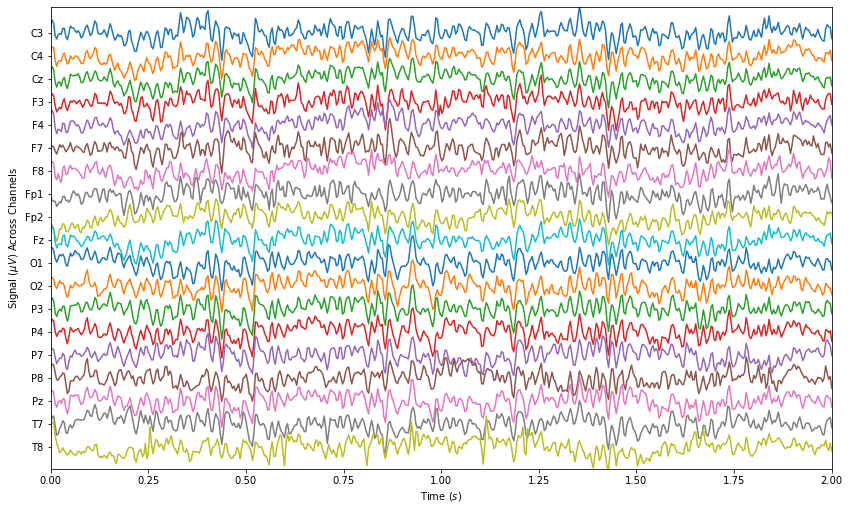

In [10]:
train_data.plot_trace(0)

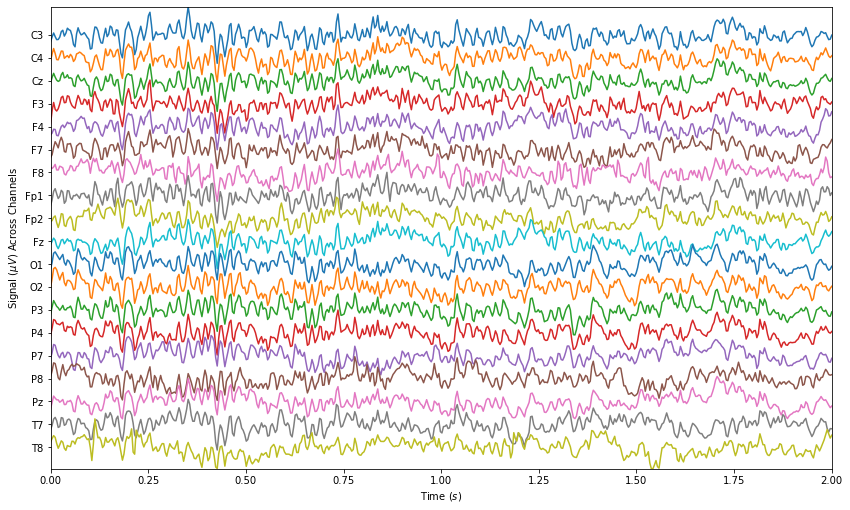

In [11]:
train_data.plot_trace(1)

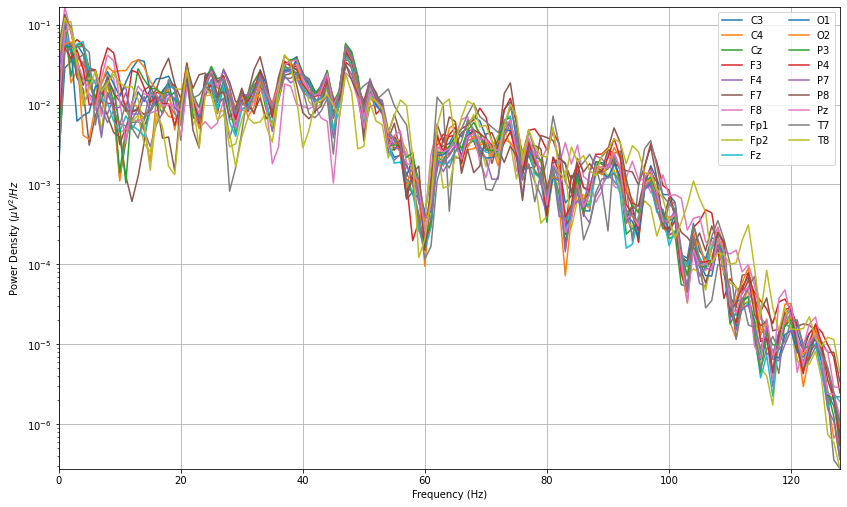

In [12]:
train_data.plot_psd(0)

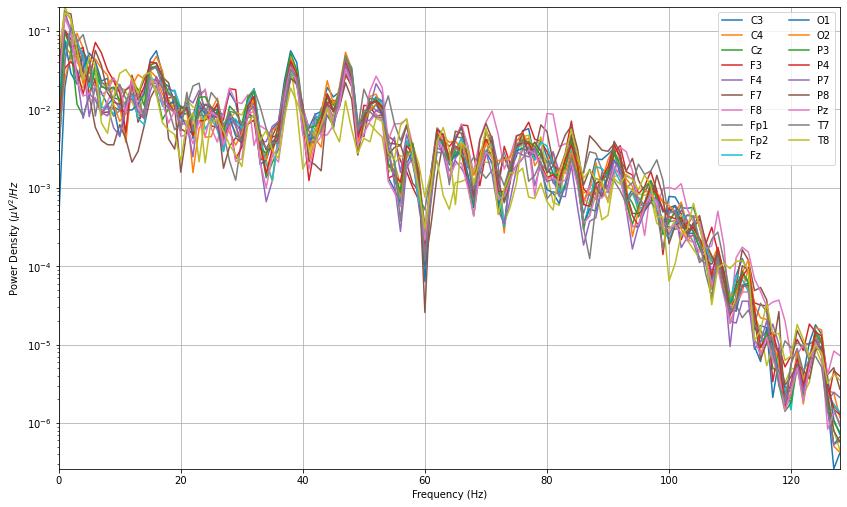

In [13]:
train_data.plot_psd(1)

## Autoencoder Networks

In [14]:
class ConvEncodeBlock(th.nn.Module):
    def __init__(self, nchan, nfilt, kernel_size, stride, transfer):
        super().__init__()

        self.conv = th.nn.Conv1d(
            nchan, nfilt,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=stride)

        self.transfer = transfer()

    def forward(self, segs):
        assert segs.ndim == 3
        return self.transfer(self.conv(segs))

In [15]:
class ResidualEncodeBlock(th.nn.Module):
    def __init__(self, nchan, nfilt, kernel_size, stride, transfer):
        super().__init__()
        
        #self.batch_norm = th.nn.BatchNorm1d(
        #    nchan, momentum=0.05)
            
        if nchan == nfilt:
            self.remix = lambda segs: segs
        else:
            self.remix = th.nn.Conv1d(nchan, nfilt, kernel_size=1)

        if stride == 1:
            self.downsample = lambda segs: segs
        else:
            self.downsample = th.nn.AvgPool1d(stride, ceil_mode=True)
        
        #self.pad = th.nn.ReflectionPad1d(kernel_size // 2)

        self.conv = th.nn.Conv1d(
            nchan, nfilt,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=stride)

        self.transfer = transfer()

        self.combine = th.nn.Conv1d(nfilt, nfilt, kernel_size=1)

    def forward(self, segs):
        assert segs.ndim == 3
        
        #norm_segs = self.batch_norm(segs)
        remix_out = self.downsample(self.remix(segs))
        resid_out = self.combine(self.transfer(self.conv(segs)))

        assert remix_out.shape == resid_out.shape
        return remix_out + resid_out

In [16]:
class Encoder(th.nn.Module):
    def __init__(self, nchan, nstep, conv_specs, transfer, block_arch):
        super().__init__()
        
        self.nchan, self.nstep = nchan, nstep

        self.output_shapes = [(nchan, nstep)]
        self.conv_specs = conv_specs
        
        if block_arch == 'conv':
            encode_block_class = ConvEncodeBlock
        elif block_arch == 'resid':
            encode_block_class = ResidualEncodeBlock
        else:
            raise ValueError(f'invalid `block_arch`: {block_arch}')

        convs = []
        layer_in, layer_out = None, self.nchan
        for nfilt, kernel_size, stride in self.conv_specs:
            layer_in, layer_out = layer_out, nfilt
        
            convs.append(
                encode_block_class(
                    layer_in, nfilt,
                    kernel_size=kernel_size,
                    stride=stride,
                    transfer=transfer))
            
            nstep = math.ceil(nstep / stride) #- kernel_size // 2
            self.output_shapes.append((layer_out, nstep))
            
        self.conv = th.nn.Sequential(*convs)
        
    def forward(self, segs):
        assert isinstance(segs, th.Tensor)

        assert segs.ndim == 3
        assert segs.shape[1] == self.nchan
        assert segs.shape[2] == self.nstep
        batch_size = segs.shape[0]                                                                  

        conv_out = self.conv(segs)
        assert conv_out.ndim == 3
        assert conv_out.shape[0] == batch_size                                                 
        assert conv_out.shape[1] == self.output_shapes[-1][0] # nfilt
        assert conv_out.shape[2] == self.output_shapes[-1][1] # nstep

        codes = conv_out.reshape(batch_size, -1)
        assert codes.ndim == 2
        assert codes.shape[0] == batch_size
        
        return codes

In [17]:
class ConvDecodeBlock(th.nn.Module):
    def __init__(self, nchan, nfilt, kernel_size, stride, transfer, output_shape):
        super().__init__()
        self.output_shape = output_shape

        self.deconv = th.nn.ConvTranspose1d(
            nchan, nfilt,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=stride)
        
        self.transfer = transfer()
        
    def forward(self, segs):
        assert segs.ndim == 3
        return self.transfer(self.deconv(segs, self.output_shape))

In [18]:
class ResidualDecodeBlock(th.nn.Module):
    def __init__(self, nchan, nfilt, kernel_size, stride, transfer, output_shape):
        super().__init__()
        self.output_shape = output_shape
        
        #self.batch_norm = th.nn.BatchNorm1d(
        #    nchan, momentum=0.05)

        if nchan == nfilt:
            self.remix = lambda segs: segs
        else:
            self.remix = th.nn.Conv1d(nchan, nfilt, kernel_size=1)

        if stride == 1:
            self.upsample = lambda segs: segs
        else:
            self.upsample = th.nn.Upsample(
                size=self.output_shape,
                mode='linear',
                align_corners=False)

        self.deconv = th.nn.ConvTranspose1d(
            nchan, nfilt,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=stride)
        
        self.transfer = transfer()

        self.combine = th.nn.Conv1d(nfilt, nfilt, kernel_size=1)
        
    def forward(self, segs):
        assert segs.ndim == 3
        
        #norm_segs = self.batch_norm(segs)
        remix_out = self.upsample(self.remix(segs))
        resid_out = self.combine(self.transfer(
            self.deconv(segs, self.output_shape)))

        assert remix_out.shape == resid_out.shape
        return remix_out + resid_out

In [19]:
class Decoder(th.nn.Module):
    def __init__(self, output_shapes, conv_specs, transfer, block_arch):
        super().__init__()
        
        self.output_shapes = output_shapes
        self.conv_specs = conv_specs
        
        if block_arch == 'conv':
            decode_block_class = ConvDecodeBlock
        elif block_arch == 'resid':
            decode_block_class = ResidualDecodeBlock
        else:
            raise ValueError(f'invalid `block_arch`: {block_arch}')

        deconvs = []
        layer_in, layer_out = None, output_shapes[0][0]
        for i, (nfilt, kernel_size, stride) in enumerate(self.conv_specs):
            layer_in, layer_out = layer_out, nfilt

            deconvs.append(
                decode_block_class(
                    layer_in, nfilt,
                    kernel_size=kernel_size,
                    stride=stride,
                    transfer=transfer,
                    output_shape=self.output_shapes[i+1][1:]))

        self.deconv = th.nn.Sequential(*deconvs)
        
        nchan, _nstep = self.output_shapes[-1]
        #self.readout = th.nn.Sequential(                                                            
        #    th.nn.BatchNorm1d(layer_out, momentum=0.05),
        #    th.nn.Conv1d(layer_out, nchan, kernel_size=1, padding=0))
        self.readout = th.nn.Conv1d(layer_out, nchan, kernel_size=1, padding=0)
    
    def forward(self, codes):
        assert isinstance(codes, th.Tensor)
        assert codes.ndim == 2
        batch_size = codes.shape[0]
                                                                                                    
        unflat_codes = codes.reshape((batch_size,) + self.output_shapes[0])
        assert unflat_codes.ndim == 3
        assert unflat_codes.shape[0] == batch_size
        assert unflat_codes.shape[1] == self.output_shapes[0][0] # nfilt
        assert unflat_codes.shape[2] == self.output_shapes[0][1] # nstep

        deconv_out = self.deconv(unflat_codes)                         
        assert deconv_out.ndim == 3
        assert deconv_out.shape[0] == batch_size
        assert deconv_out.shape[2] == self.output_shapes[-1][1] # nstep

        segs = self.readout(deconv_out)
        assert segs.ndim == 3
        assert segs.shape[0] == batch_size
        assert segs.shape[1] == self.output_shapes[-1][0] # nchan
        assert segs.shape[2] == self.output_shapes[-1][1] # nstep

        return segs

In [20]:
class Autoencoder(th.nn.Module):
    def __init__(self, nchan, nstep, conv_specs, transfer=th.nn.ReLU, block_arch='conv'):
        super().__init__()

        assert nchan > 0
        assert nstep > 0
        self.nchan, self.nstep = nchan, nstep
        
        assert isinstance(conv_specs, tuple)
        self.conv_specs = conv_specs

        assert issubclass(transfer, th.nn.Module)
                                                                                            
        self.encoder = Encoder(
            nchan=self.nchan,
            nstep=self.nstep,
            conv_specs=self.conv_specs,
            transfer=transfer,
            block_arch=block_arch)

        rev_conv_specs = tuple(reversed(self.conv_specs))
        rev_output_shapes = tuple(reversed(self.encoder.output_shapes))
                                                                                                    
        self.decoder = Decoder(
            output_shapes=rev_output_shapes,
            conv_specs=rev_conv_specs,
            transfer=transfer,
            block_arch=block_arch)
                                                                                                                                                                                                        
    def forward(self, segs):                                                                        
        return self.decoder(self.encoder(segs))                                                     

    def recon(self, segs):
        return self(segs).detach()
    
    @property
    def nparameters(self):
        return sum(p.nelement() for p in self.parameters())
    
    def save(self, filename):
        with open(filename, mode='wb') as fh:                                                  
            th.save(self.state_dict(), fh)

## Training

In [21]:
def train_adam(model, train_data, valid_data, max_epochs=500, stop_epochs=50,
               learning_rate=0.0125, learning_rate_decay=0.996, loss_method='huber',
               clip_norm=6, batch_size=256, load_workers=0, use_gpu=True):
    train_loader = th.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        pin_memory=use_gpu,
        num_workers=load_workers,
        drop_last=False,
        shuffle=False)

    valid_loader = th.utils.data.DataLoader(
        valid_data,
        batch_size=batch_size,
        pin_memory=use_gpu,
        num_workers=load_workers,
        shuffle=False)

    if use_gpu:
        model.cuda()

    train_losses = []
    valid_losses = []

    best_train_loss = float('inf')
    best_valid_loss = float('inf')
    best_epoch = 0
    best_state = None

    if loss_method == 'mse':
        loss_func = th.nn.MSELoss(reduction='mean')
    elif loss_method == 'huber':
        loss_func = th.nn.SmoothL1Loss(reduction='mean')
    else:
        raise ValueError(f'invalid `loss_method`: {loss_method}')
    
    # all parameters with `requires_grad` set
    parameters = list(filter(lambda param: param.requires_grad, model.parameters()))
        
    # initialize the optimizer
    optimizer = th.optim.Adam(parameters, lr=learning_rate)
        
    # exponential learning rate decay
    lr_scheduler = th.optim.lr_scheduler.ExponentialLR(optimizer, learning_rate_decay)
        
    for epoch in range(max_epochs):                                                                                                    
        # enter training mode
        model.train()

        # training pass
        epoch_train_losses = []
        for i, segs in enumerate(train_loader):
            optimizer.zero_grad()
            
            if use_gpu:
                segs = segs.cuda()

            recons = model(segs)
            loss = loss_func(recons, segs)

            loss_f = loss.item()
            epoch_train_losses.append(loss_f)

            loss.backward()

            if clip_norm is not None:
                th.nn.utils.clip_grad_norm_(parameters, clip_norm)

            optimizer.step()

        train_losses.append(np.mean(epoch_train_losses))
            
        # back to evaluation mode
        model.eval()

        # validation loss
        with th.no_grad():
            epoch_valid_losses = []
            for i, segs in enumerate(valid_loader):
                if use_gpu:
                    segs = segs.cuda()

                recons = model(segs)
                loss = loss_func(recons, segs)

                loss_f = loss.item()
                epoch_valid_losses.append(loss_f)

        valid_losses.append(np.mean(epoch_valid_losses))
            
        if valid_losses[-1] < best_valid_loss:
            best_train_loss = train_losses[-1]
            best_valid_loss = valid_losses[-1]
            best_epoch = epoch
            best_state = copy.deepcopy(model.state_dict())

        print('epoch:', epoch)
        print('learning rate:', next(iter(optimizer.param_groups))['lr'])
        print('train loss:', train_losses[-1])
        print('valid loss:', valid_losses[-1])
        print('best epoch:', best_epoch)
        print('=======')
                
        if (best_epoch + stop_epochs) <= epoch:
            print(f'terminating after {stop_epochs} of no improvement')
            break

        lr_scheduler.step()

    if best_state is None:
        raise RuntimeError('best state not set!')

    model.load_state_dict(best_state)

    if use_gpu:
        model.cpu()

    return munch.munchify({
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'best_train_loss': best_train_loss,
        'best_valid_loss': best_valid_loss,
        'best_epoch': best_epoch,
    })

In [22]:
def train_rprop(model, train_data, valid_data, max_epochs=500, stop_epochs=50,
                init_step=0.01, loss_method='huber', batch_size=256, load_workers=0,
                use_gpu=True):

    train_loader = th.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        pin_memory=use_gpu,
        num_workers=load_workers,
        drop_last=False,
        shuffle=False)

    valid_loader = th.utils.data.DataLoader(
        valid_data,
        batch_size=batch_size,
        pin_memory=use_gpu,
        num_workers=load_workers,
        shuffle=False)

    if use_gpu:
        model.cuda()

    train_losses = []
    valid_losses = []

    best_train_loss = float('inf')
    best_valid_loss = float('inf')
    best_epoch = 0
    best_state = None

    if loss_method == 'mse':
        loss_func = th.nn.MSELoss(reduction='mean')
    elif loss_method == 'huber':
        loss_func = th.nn.SmoothL1Loss(reduction='mean')
    else:
        raise ValueError(f'invalid `loss_method`: {loss_method}')
    
    # all parameters with `requires_grad` set
    parameters = list(filter(lambda param: param.requires_grad, model.parameters()))
        
    # initialize the optimizer
    optimizer = th.optim.Rprop(parameters, lr=init_step)
        
    for epoch in range(max_epochs):                                                                                                    
        # enter training mode
        model.train()

        # zero gradients
        # outside of the batch loop since gradients are accumulated
        optimizer.zero_grad()
        
        # training pass
        epoch_train_losses = []
        for i, segs in enumerate(train_loader):
            if use_gpu:
                segs = segs.cuda()

            recons = model(segs)
            loss = loss_func(recons, segs)

            loss_f = loss.item()
            epoch_train_losses.append(loss_f)

            loss.backward()

        optimizer.step()

        train_losses.append(np.mean(epoch_train_losses))
            
        # back to evaluation mode
        model.eval()

        # validation loss
        with th.no_grad():
            epoch_valid_losses = []
            for i, segs in enumerate(valid_loader):
                if use_gpu:
                    segs = segs.cuda()

                recons = model(segs)
                loss = loss_func(recons, segs)

                loss_f = loss.item()
                epoch_valid_losses.append(loss_f)

        valid_losses.append(np.mean(epoch_valid_losses))
            
        if valid_losses[-1] < best_valid_loss:
            best_train_loss = train_losses[-1]
            best_valid_loss = valid_losses[-1]
            best_epoch = epoch
            best_state = copy.deepcopy(model.state_dict())

        print('epoch:', epoch)
        print('train loss:', train_losses[-1])
        print('valid loss:', valid_losses[-1])
        print('best epoch:', best_epoch)
        print('=======')
                
        if (best_epoch + stop_epochs) <= epoch:
            print(f'terminating after {stop_epochs} of no improvement')
            break

    if best_state is None:
        raise RuntimeError('best state not set!')

    model.load_state_dict(best_state)

    if use_gpu:
        model.cpu()

    return munch.munchify({
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'best_train_loss': best_train_loss,
        'best_valid_loss': best_valid_loss,
        'best_epoch': best_epoch,
    })

In [24]:
def train(model, train_data, valid_data, optim_method='rprop', **kwargs):
    if optim_method == 'rprop':
        return train_rprop(model, train_data, valid_data, **kwargs)
    elif optim_method == 'adam':
        return train_adam(model, train_data, valid_data, **kwargs)
    else:
        raise ValueError(f'invalid `optim_method`: {optim_method}')

## Convolution-only Autoencoders

In [27]:
autoencoder = Autoencoder(
    nchan=train_data.nchan,
    nstep=train_data.nstep,
    #conv_specs=((32, 21, 1), (32, 19, 2),  # 128Hz
    #            (48, 17, 1), (48, 15, 2),  # 64Hz
    #            (64, 13, 1), (64, 11, 2),  # 32Hz
    #            (80,  9, 1), (80,  7, 2),  # 16Hz
    #            (96,  5, 1), (96,  3, 2)),  # 8Hz
    #            #(72,  3, 1), (72,  3, 2)), # 4Hz
    #conv_specs=(
    #    (32, 19, 2),  # 128Hz
    #    (48, 15, 2),  # 64Hz
    #    (64, 11, 2),  # 32Hz
    #    (80,  7, 2),  # 16Hz
    #    (96,  5, 2),  # 8Hz
    #    (112, 3, 2)), # 4Hz
    conv_specs=((32, 11, 1), (32, 11, 2),
                (48,  9, 1), (48,  9, 2)),
    block_arch='conv',
    transfer=th.nn.ReLU)

autoencoder

Autoencoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): ConvEncodeBlock(
        (conv): Conv1d(19, 32, kernel_size=(11,), stride=(1,), padding=(5,))
        (transfer): ReLU()
      )
      (1): ConvEncodeBlock(
        (conv): Conv1d(32, 32, kernel_size=(11,), stride=(2,), padding=(5,))
        (transfer): ReLU()
      )
      (2): ConvEncodeBlock(
        (conv): Conv1d(32, 48, kernel_size=(9,), stride=(1,), padding=(4,))
        (transfer): ReLU()
      )
      (3): ConvEncodeBlock(
        (conv): Conv1d(48, 48, kernel_size=(9,), stride=(2,), padding=(4,))
        (transfer): ReLU()
      )
    )
  )
  (decoder): Decoder(
    (deconv): Sequential(
      (0): ConvDecodeBlock(
        (deconv): ConvTranspose1d(48, 48, kernel_size=(9,), stride=(2,), padding=(4,))
        (transfer): ReLU()
      )
      (1): ConvDecodeBlock(
        (deconv): ConvTranspose1d(48, 48, kernel_size=(9,), stride=(1,), padding=(4,))
        (transfer): ReLU()
      )
      (2): ConvDecodeBloc

Total number of parameters in the autoencoder:

In [28]:
sum(p.nelement() for p in autoencoder.parameters())

123091

In [29]:
first_segment = train_data[0]

In [30]:
first_segment.shape, first_segment.shape[0] * first_segment.shape[1]

(torch.Size([19, 512]), 9728)

In [31]:
autoencoder.eval()
autoencoder.encoder(first_segment[None, ...]).shape

torch.Size([1, 6144])

In [32]:
autoencoder.encoder.output_shapes

[(19, 512), (32, 512), (32, 256), (48, 256), (48, 128)]

In [33]:
recon = autoencoder.recon(first_segment[None, ...])
recon.shape, recon.min(), recon.max()

(torch.Size([1, 19, 512]), tensor(-0.2185), tensor(0.1667))

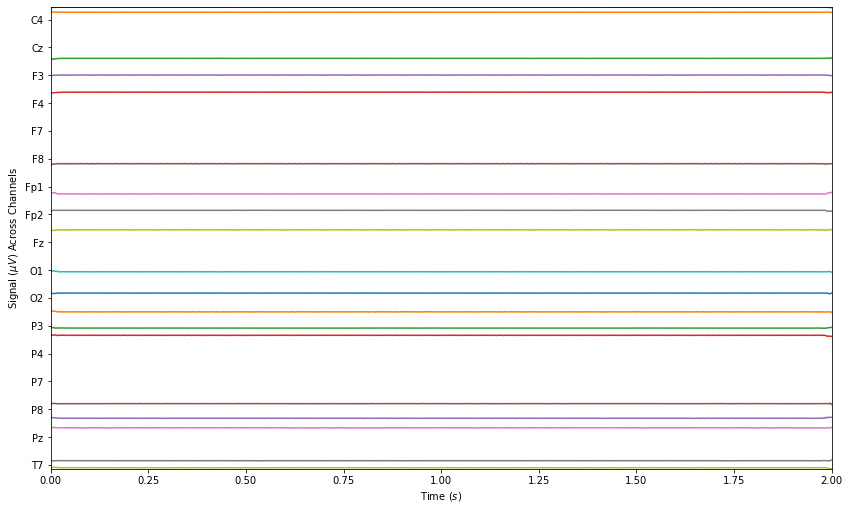

In [34]:
train_data.plot_trace(recon[0])

In [35]:
train_result = train(autoencoder, train_data, valid_data, optim_method='rprop', use_gpu=False)

epoch: 0
train loss: 0.4191292415304882
valid loss: 0.42274950941403705
best epoch: 0
epoch: 1
train loss: 0.4180981153395118
valid loss: 0.4142890324195226
best epoch: 1
epoch: 2
train loss: 0.41032826973170766
valid loss: 6.550338586171468
best epoch: 1
epoch: 3
train loss: 5.927029760872445
valid loss: 2.737435062726339
best epoch: 1
epoch: 4
train loss: 2.4811561863596845
valid loss: 0.4150729477405548
best epoch: 1
epoch: 5
train loss: 0.41130162957237987
valid loss: 0.4101048211256663
best epoch: 5
epoch: 6
train loss: 0.40673939774676066
valid loss: 0.4378349979718526
best epoch: 5
epoch: 7
train loss: 0.431770177876077
valid loss: 0.39610061546166736
best epoch: 7
epoch: 8
train loss: 0.3951340913772583
valid loss: 0.3455078403155009
best epoch: 8
epoch: 9
train loss: 0.3481513879648069
valid loss: 0.7119894226392111
best epoch: 8
epoch: 10
train loss: 0.7192976634676863
valid loss: 0.4733416438102722
best epoch: 8
epoch: 11
train loss: 0.47215056492061147
valid loss: 0.4397719

epoch: 86
train loss: 0.2386990222262173
valid loss: 0.2186975379784902
best epoch: 86
epoch: 87
train loss: 0.2379581728359548
valid loss: 0.21753699332475662
best epoch: 87
epoch: 88
train loss: 0.2370290301921891
valid loss: 0.21754569560289383
best epoch: 87
epoch: 89
train loss: 0.23650094794064033
valid loss: 0.21578524261713028
best epoch: 89
epoch: 90
train loss: 0.23540240417166455
valid loss: 0.2142822965979576
best epoch: 90
epoch: 91
train loss: 0.2342723368144617
valid loss: 0.2128110726674398
best epoch: 91
epoch: 92
train loss: 0.23314059216801714
valid loss: 0.2120097577571869
best epoch: 92
epoch: 93
train loss: 0.23205777639295996
valid loss: 0.20999651650587717
best epoch: 93
epoch: 94
train loss: 0.23091467415414205
valid loss: 0.2086838334798813
best epoch: 94
epoch: 95
train loss: 0.2296975513057011
valid loss: 0.2069189449151357
best epoch: 95
epoch: 96
train loss: 0.22847032728718547
valid loss: 0.20537716646989188
best epoch: 96
epoch: 97
train loss: 0.22707651

epoch: 170
train loss: 0.18480765619655934
valid loss: 0.16521073877811432
best epoch: 170
epoch: 171
train loss: 0.18434330039634939
valid loss: 0.16491461296876272
best epoch: 171
epoch: 172
train loss: 0.18391615861072774
valid loss: 0.164664164185524
best epoch: 172
epoch: 173
train loss: 0.18348904826292178
valid loss: 0.1643023118376732
best epoch: 173
epoch: 174
train loss: 0.18306128680706024
valid loss: 0.16408164550860724
best epoch: 174
epoch: 175
train loss: 0.18264637069731224
valid loss: 0.16368590543667474
best epoch: 175
epoch: 176
train loss: 0.18219419568777084
valid loss: 0.168345645070076
best epoch: 175
epoch: 177
train loss: 0.18681712103326145
valid loss: 0.16694476455450058
best epoch: 175
epoch: 178
train loss: 0.18527647616659723
valid loss: 0.1633604938785235
best epoch: 178
epoch: 179
train loss: 0.18176327209647108
valid loss: 0.16291815539201102
best epoch: 179
epoch: 180
train loss: 0.18135269113430164
valid loss: 0.16255606710910797
best epoch: 180
epoch

epoch: 254
train loss: 0.15052818615988986
valid loss: 0.13738515973091125
best epoch: 254
epoch: 255
train loss: 0.15017975957655325
valid loss: 0.1371121716996034
best epoch: 255
epoch: 256
train loss: 0.149842768907547
valid loss: 0.1368886406222979
best epoch: 256
epoch: 257
train loss: 0.14950339387102826
valid loss: 0.13658285389343897
best epoch: 257
epoch: 258
train loss: 0.14918128146630963
valid loss: 0.13635581359267235
best epoch: 258
epoch: 259
train loss: 0.1488518947508277
valid loss: 0.13609377791484198
best epoch: 259
epoch: 260
train loss: 0.14852090434330265
valid loss: 0.13587058956424394
best epoch: 260
epoch: 261
train loss: 0.14822447772433117
valid loss: 0.13562009980281195
best epoch: 261
epoch: 262
train loss: 0.1479060982422131
valid loss: 0.139188123246034
best epoch: 261
epoch: 263
train loss: 0.1537127856437753
valid loss: 0.13789878661433855
best epoch: 261
epoch: 264
train loss: 0.15189878097394618
valid loss: 0.13596205785870552
best epoch: 261
epoch: 2

epoch: 338
train loss: 0.13466899296859416
valid loss: 0.12441900496681531
best epoch: 338
epoch: 339
train loss: 0.13453558523480486
valid loss: 0.12435575698812802
best epoch: 339
epoch: 340
train loss: 0.13444642504540885
valid loss: 0.12427204474806786
best epoch: 340
epoch: 341
train loss: 0.13435096747991515
valid loss: 0.12417678038279216
best epoch: 341
epoch: 342
train loss: 0.13424620631991363
valid loss: 0.12409435585141182
best epoch: 342
epoch: 343
train loss: 0.13414493566606103
valid loss: 0.12400219589471817
best epoch: 343
epoch: 344
train loss: 0.13402186933814025
valid loss: 0.12389134118954341
best epoch: 344
epoch: 345
train loss: 0.13388660368396016
valid loss: 0.12374533464511235
best epoch: 345
epoch: 346
train loss: 0.13374628381031314
valid loss: 0.12362651775280635
best epoch: 346
epoch: 347
train loss: 0.1336012413588966
valid loss: 0.12348826105395953
best epoch: 347
epoch: 348
train loss: 0.13346755595468893
valid loss: 0.12339821457862854
best epoch: 348


epoch: 422
train loss: 0.13655462315896663
valid loss: 0.12425731122493744
best epoch: 420
epoch: 423
train loss: 0.13284923772259458
valid loss: 0.11556148901581764
best epoch: 420
epoch: 424
train loss: 0.12294484602241981
valid loss: 0.11543292303880055
best epoch: 420
epoch: 425
train loss: 0.12279916100385713
valid loss: 0.11516100913286209
best epoch: 425
epoch: 426
train loss: 0.1224802645241342
valid loss: 0.11508852243423462
best epoch: 426
epoch: 427
train loss: 0.12239064094496936
valid loss: 0.11499753221869469
best epoch: 427
epoch: 428
train loss: 0.12229190148958345
valid loss: 0.11493672182162602
best epoch: 428
epoch: 429
train loss: 0.12221908896434598
valid loss: 0.1148705780506134
best epoch: 429
epoch: 430
train loss: 0.12212161701626895
valid loss: 0.11478862663110097
best epoch: 430
epoch: 431
train loss: 0.12200489294965093
valid loss: 0.1147232415775458
best epoch: 431
epoch: 432
train loss: 0.12189382314682007
valid loss: 0.11464911575118701
best epoch: 432
ep

In [36]:
autoencoder.save('conv_only_autoencoder_rprop.pkl')

(0.0, 1.0)

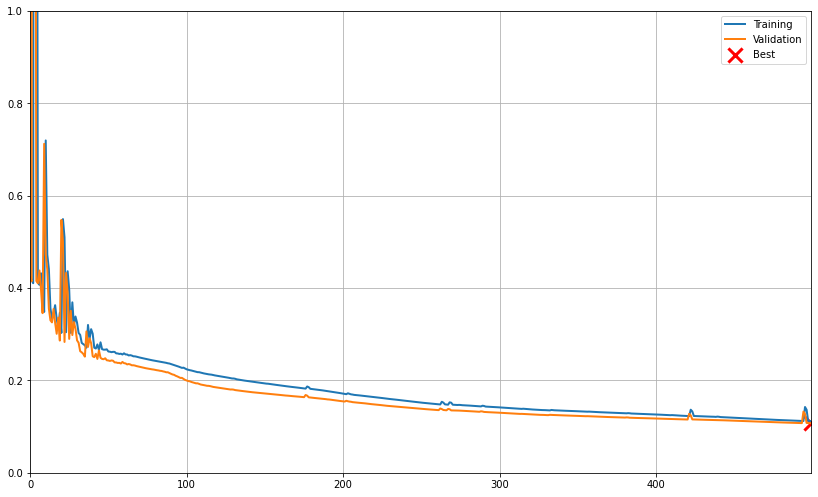

In [37]:
fig_loss = plt.figure()
ax_loss = fig_loss.add_subplot(1, 1, 1)
ax_loss.plot(train_result.train_losses, linewidth=2, label='Training')
ax_loss.plot(train_result.valid_losses, linewidth=2, label='Validation')
ax_loss.scatter(
    (train_result.best_epoch,), (train_result.best_valid_loss,),
    linewidth=3, s=200, marker='x', color='red', label='Best')
ax_loss.legend()
ax_loss.autoscale(tight=True)
ax_loss.grid();
ax_loss.set_ylim((0.0, 1.0))

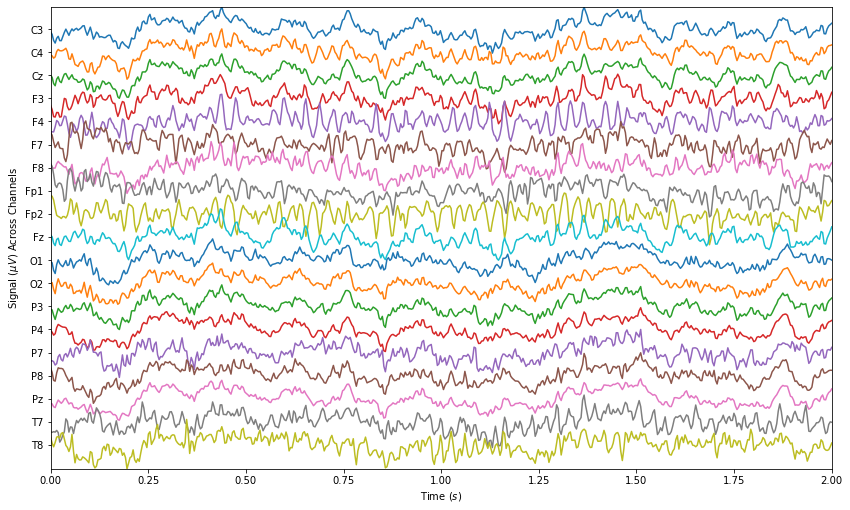

In [38]:
first_segment = valid_data[0]
valid_data.plot_trace(first_segment)

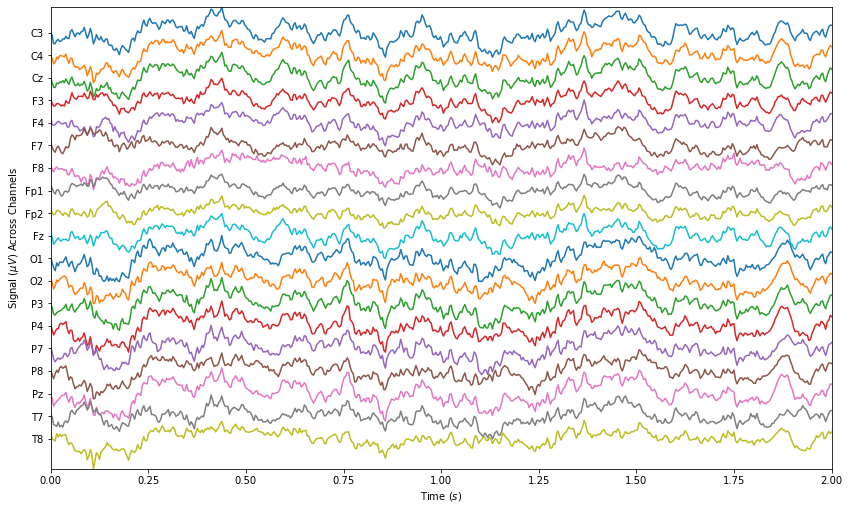

In [39]:
recon = autoencoder.recon(first_segment[None, ...])
valid_data.plot_trace(recon[0])

an encoded segment

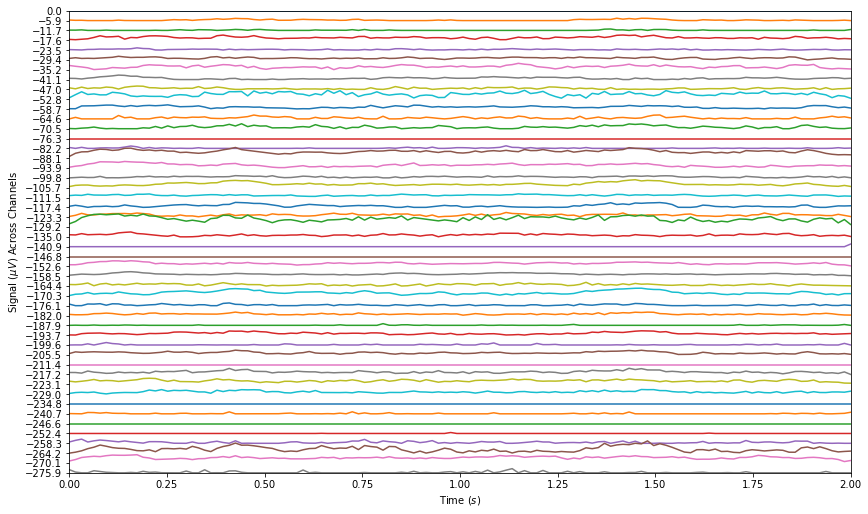

In [40]:
encoded_flat = autoencoder.encoder(first_segment[None, ...]).detach()
encoded = encoded_flat.reshape(autoencoder.conv_specs[-1][0], -1)

# need to make plot_trace free standing

def plot_trace(segment, samp_rate, chan_names=None, scale_factor=0.75):
    segment = segment.T
        
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    nsec = segment.shape[0] / samp_rate
    
    nchan = segment.shape[1]
    
    scale = th.max(th.abs(segment))                                                                                                                                                                   
    sep = -th.arange(segment.shape[1]) * scale_factor * scale
    segment = segment + sep
        
    time = th.linspace(0, nsec, segment.shape[0])
    
    ax.plot(time, segment)
    ax.set_xlabel(r'Time ($s$)')
    ax.set_ylabel(r'Signal ($\mu V$) Across Channels')
    ax.set_yticks(sep)
    if chan_names:
        ax.set_yticklabels([c for i, c in enumerate(chan_names)])
    ax.autoscale(tight=True)
        
# samp rate assumes 2-second segments
plot_trace(encoded, samp_rate=encoded.shape[1] / 2.0)

the residuals

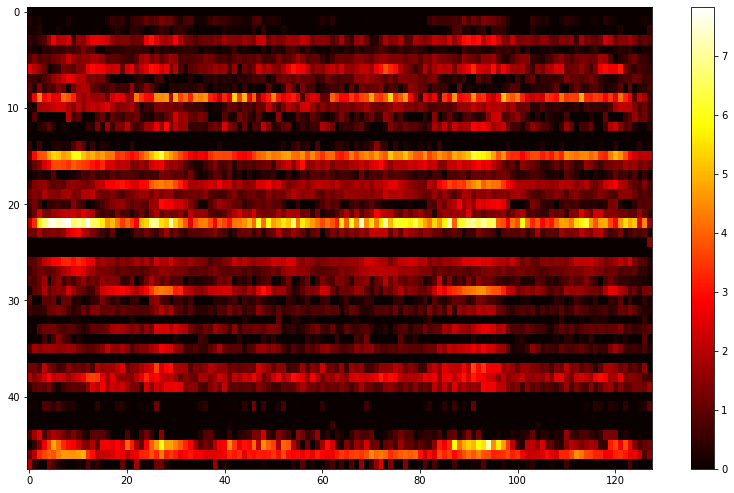

In [41]:
plt.imshow(encoded, aspect='auto', interpolation='none', cmap=plt.cm.hot);
plt.colorbar();

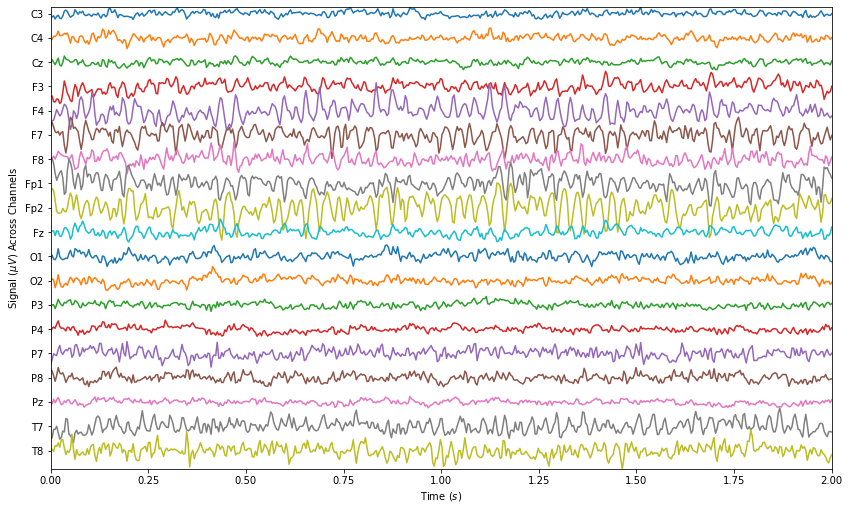

In [42]:
valid_data.plot_trace(first_segment - recon[0])

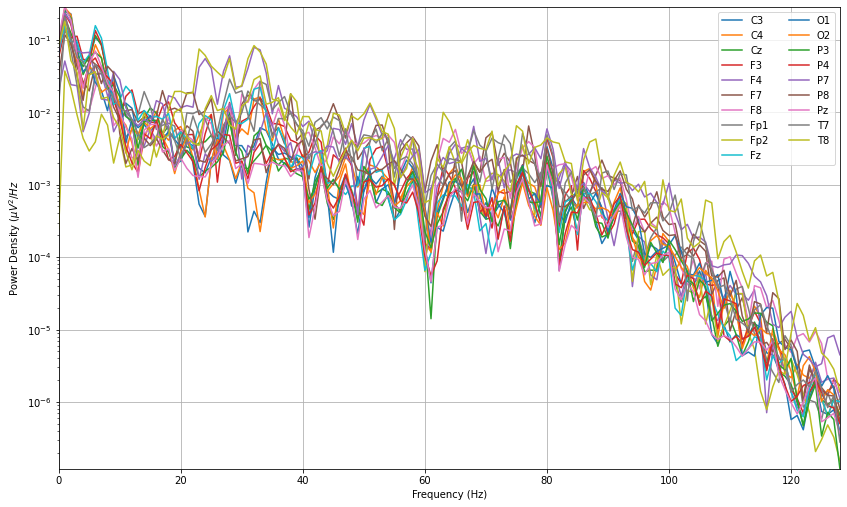

In [43]:
valid_data.plot_psd(first_segment)

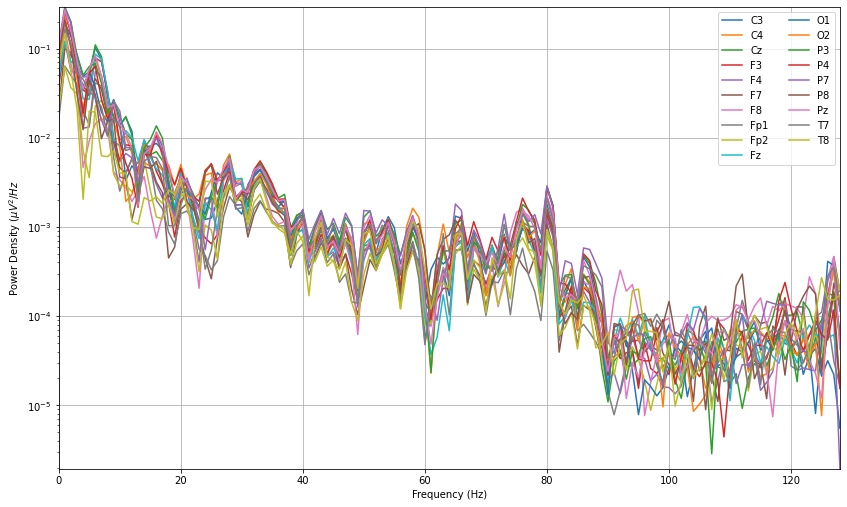

In [44]:
valid_data.plot_psd(recon[0])

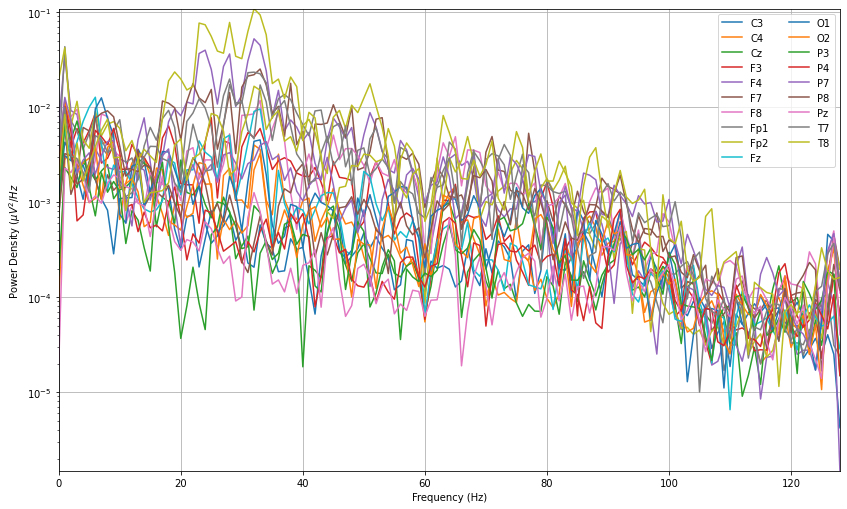

In [45]:
valid_data.plot_psd(first_segment - recon[0])

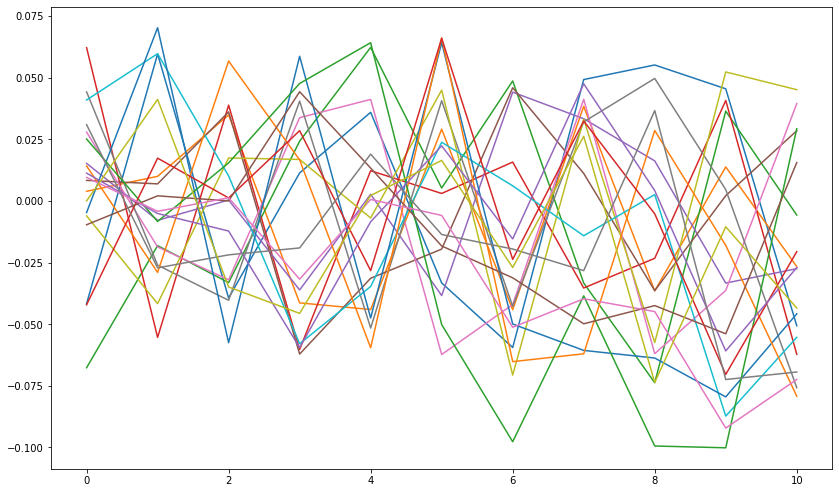

In [46]:
plt.plot(autoencoder.encoder.conv[0].conv.weight[0].detach().T);

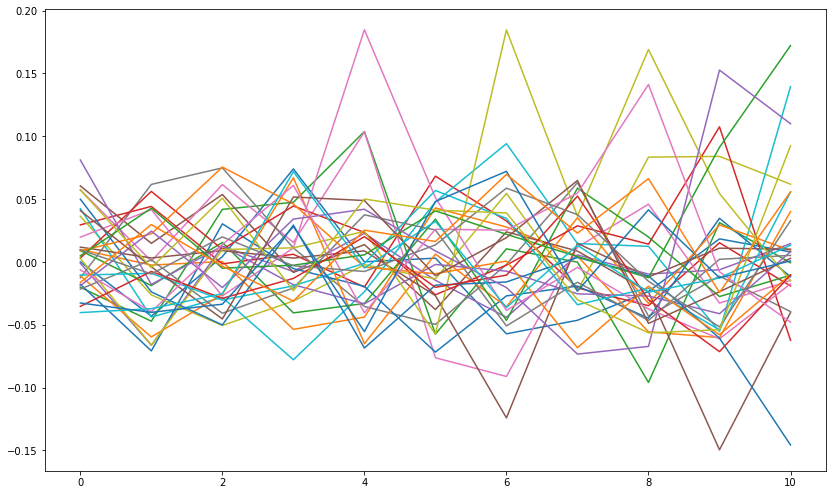

In [47]:
plt.plot(autoencoder.encoder.conv[1].conv.weight[0].detach().T);

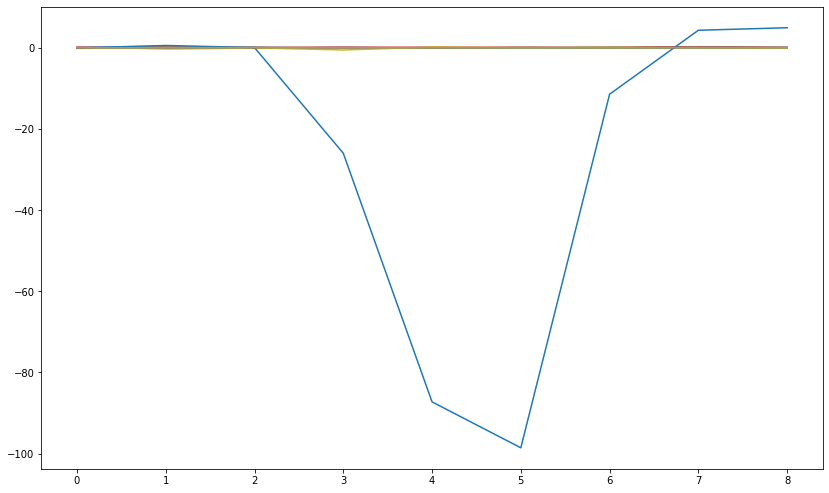

In [48]:
plt.plot(autoencoder.encoder.conv[2].conv.weight[0].detach().T);